In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
import pickle

2024-09-29 23:33:53.877850: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-29 23:33:54.189558: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-29 23:33:54.189614: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-29 23:33:54.237908: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-29 23:33:54.339456: I tensorflow/core/platform/cpu_feature_guar

In [2]:
print(tf.__version__)
print(tf.config.list_physical_devices())

2.15.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-09-29 23:33:57.022104: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-09-29 23:33:57.195876: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-09-29 23:33:57.195927: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_virtual_device_configuration(
                gpu,
                [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)])  # Set your memory limit here
    except RuntimeError as e:
        print(e)

In [4]:
def inverse_convert_time_window(data_3d):
    samples, timesteps, variables = data_3d.shape
    data_2d = np.zeros((samples + timesteps - 1, variables))

    count = np.zeros((samples + timesteps - 1, variables))

    for i in range(samples):
        data_2d[i:i+timesteps] += data_3d[i]
        count[i:i+timesteps] += 1

    # Average the overlapping segments
    data_2d /= count
    return data_2d

In [5]:
def convert_time_window(data, timesteps):
    samples = data.shape[0] - timesteps + 1  # Number of samples in the new 3D array
    variables = data.shape[1]  # Number of variables (features)

    data_3d = np.zeros((samples, timesteps, variables))

    for i in range(samples):
        data_3d[i] = data[i:i+timesteps]
    return data_3d

In [6]:
def calculate_reconstruction_loss(data, reconstructions):
    reconstruction_errors = np.mean(np.abs(data - reconstructions), axis=1)
    total_r_e = np.sum(reconstruction_errors)
    relative_reconstruction_errors = np.array([(r_e / total_r_e) * 100 for r_e in reconstruction_errors])
    return reconstruction_errors

In [7]:
def find_optimal_threshold(reconstruction_errors, y_true):
    from sklearn.metrics import accuracy_score, balanced_accuracy_score

    best_threshold = 0.0
    best_f1 = 0.0
    best_y_pred = np.zeros(reconstruction_errors.shape)
    # q3 = np.percentile(reconstruction_errors, 75)
    # q1 = np.percentile(reconstruction_errors, 25)
    # iqr = q3 - q1
    upper_bound = np.max(reconstruction_errors)
    lower_bound = np.min(reconstruction_errors)

    thresholds = np.linspace(lower_bound, upper_bound, num=1000)

    for threshold in thresholds:
        y_pred = np.where((reconstruction_errors > threshold) ,1, 0)
        # print(y_pred.shape)
        # print(y_true.shape)

        # Hitung F1-Score
        current_f1 = balanced_accuracy_score(y_true.astype(bool), y_pred.astype(bool))

        if current_f1 > best_f1:
            best_f1 = current_f1
            best_threshold = threshold
            best_y_pred = y_pred

    return best_threshold, best_f1, best_y_pred

# def find_optimal_threshold(reconstruction_errors, y_true):
#     from sklearn.metrics import f1_score, accuracy_score
    
#     best_threshold = 0.0
#     best_f1 = 0.0
#     best_y_pred = np.zeros(reconstruction_errors.shape)
#     q3 = np.percentile(reconstruction_errors, 75)
#     q1 = np.percentile(reconstruction_errors, 25)
#     iqr = q3 - q1
#     upper_bound = max(np.max(reconstruction_errors) / 2, (q3 + iqr * 1.5))
#     lower_bound = min(np.min(reconstruction_errors) / 2, (q1 - iqr * 1.5))

#     thresholds = np.linspace(lower_bound, upper_bound, num=500)

#     for threshold in thresholds:
#         y_pred = np.where(
#             (reconstruction_errors > (threshold + iqr)) | 
#             (reconstruction_errors < (threshold - iqr)),
#               1, 0)
#         # print(y_pred.shape)
#         # print(y_true.shape)

#         current_f1 = accuracy_score(y_true.astype(bool), y_pred.astype(bool))

#         if current_f1 > best_f1:
#             best_f1 = current_f1
#             best_threshold = threshold
#             best_y_pred = y_pred

#     return best_threshold, best_f1, best_y_pred

## ================================================================

In [8]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import pickle

df = pd.read_csv("../../datasets/turbine-gas-gearbox/BLD-LGC PTGBX 26 JUL21-8FEB23_edited.csv", index_col='Timestamp')

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)
pickle.dump(scaler, open('StandardScaler-gearbox.pkl', 'wb'))

<Axes: >

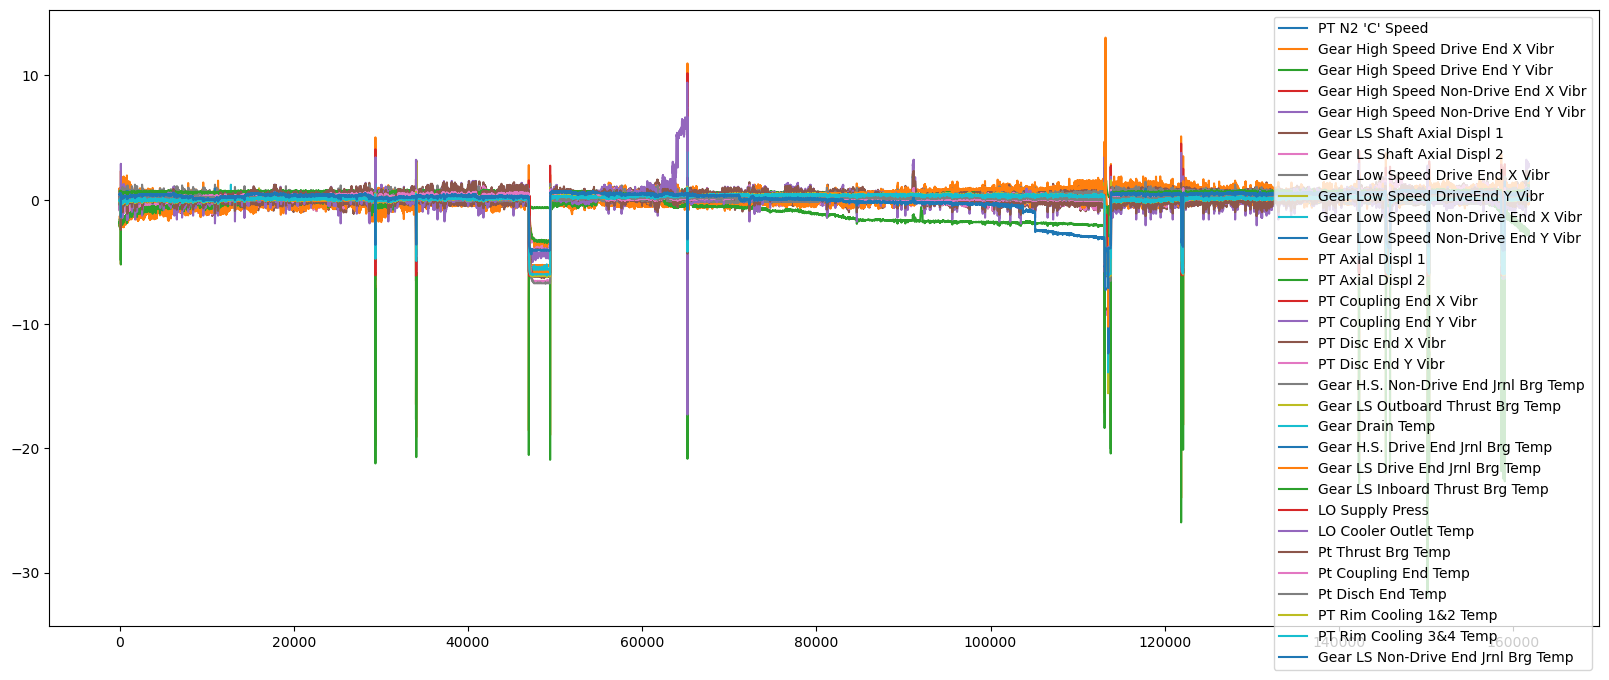

In [9]:
pd.DataFrame(df_scaled, columns=df.columns).plot(figsize=(20,8))

In [10]:
df.shape
# if 'Gear LS Inboard Thrust Brg Temp' in df.columns:
#     df.drop('Gear LS Inboard Thrust Brg Temp', axis=1, inplace=True)

(161788, 31)

In [11]:
df_sample = df.reset_index().loc[:60000-1]
df_sample.to_csv("../../datasets/turbine-gas-gearbox/data_sample.csv", index=False)

In [12]:
df_sample_test = df.reset_index().loc[60000:70000-1]
df_sample_test.to_csv("../../datasets/turbine-gas-gearbox/data_sample_test.csv", index=False)

## ==========================================

In [8]:
df_sample = pd.read_csv("../../datasets/turbine-gas-gearbox/data_sample.csv", index_col="Timestamp")
print(df_sample.shape)

(60000, 31)


In [9]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import pickle

# scaler = MinMaxScaler([0,1])
scaler = pickle.load(open('StandardScaler-gearbox.pkl', 'rb'))
df_sample_scaled = scaler.transform(df_sample)

[]

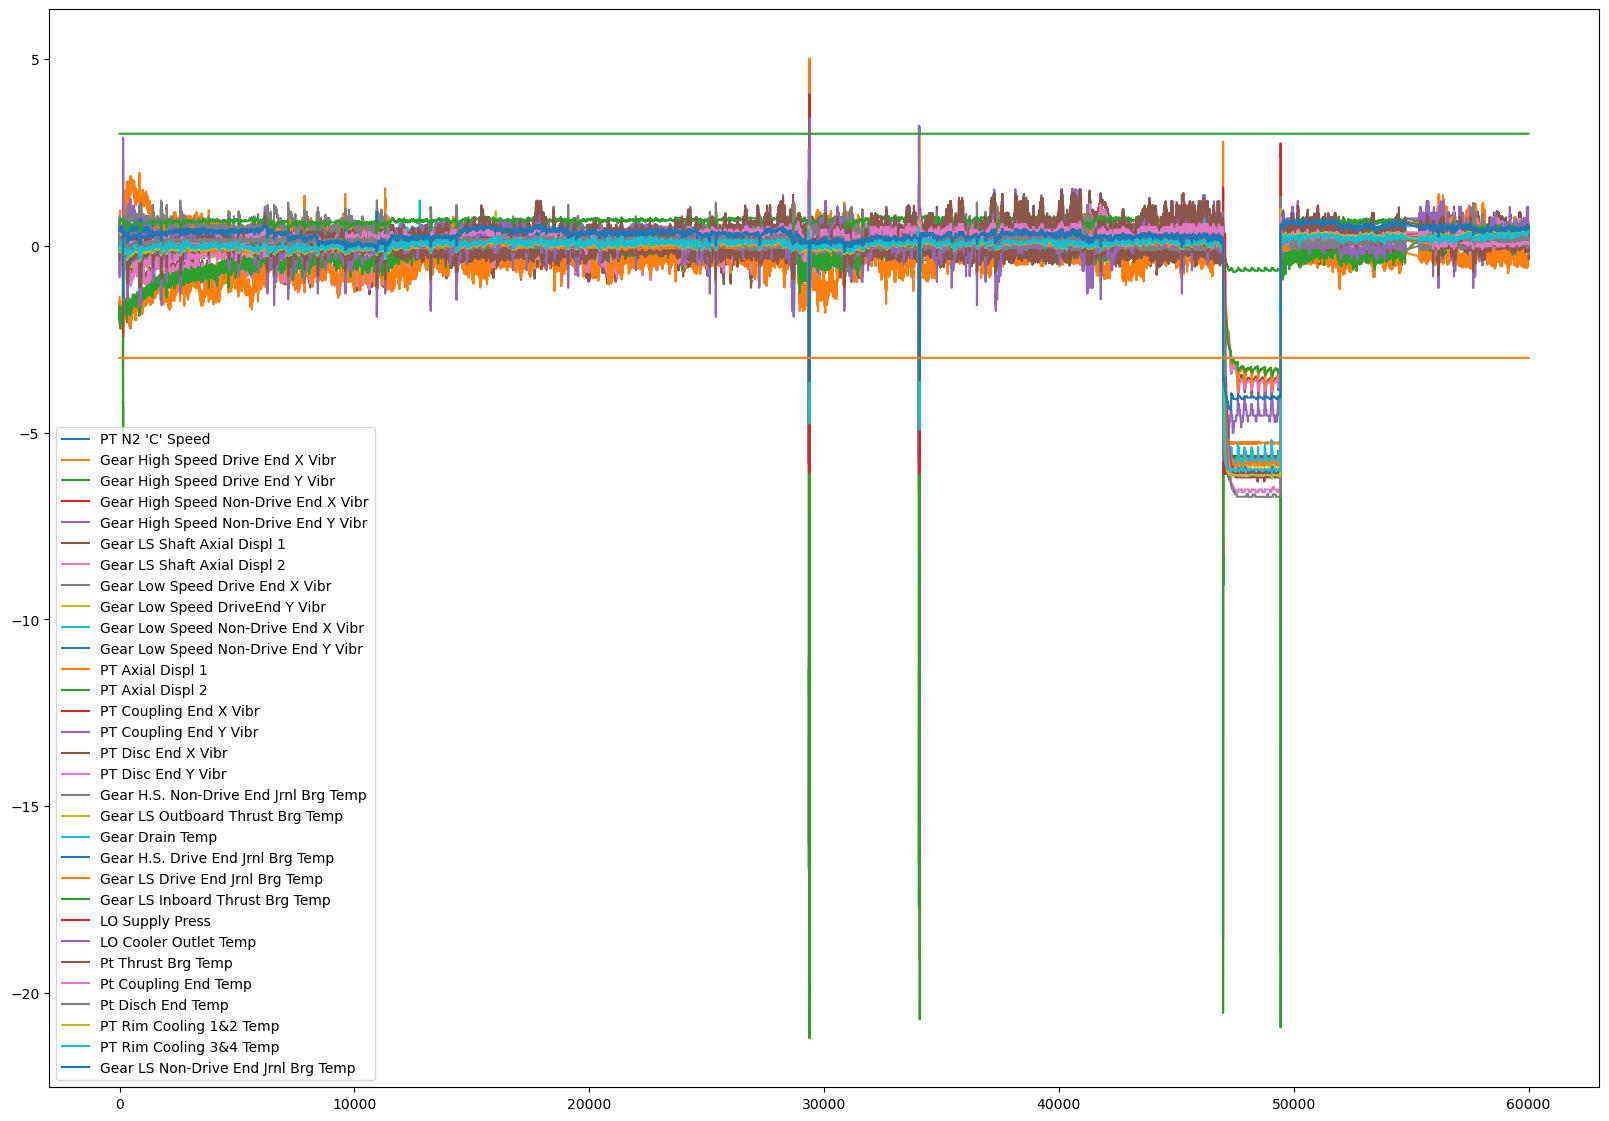

In [10]:
plt.figure(figsize=(20,14))
plt.plot(df_sample_scaled)
plt.plot(np.full(df_sample_scaled.shape[0], -3))
plt.plot(np.full(df_sample_scaled.shape[0], 3))
plt.legend(df_sample.columns)
plt.plot()

In [11]:
df_sample['label'] = np.where(np.any((df_sample_scaled < -3) | (df_sample_scaled > 3), axis=1), 1, 0)

In [13]:
# from sklearn.neighbors import LocalOutlierFactor
# lof = LocalOutlierFactor()

# yyy = lof.fit_predict(df_sample_scaled)

[]

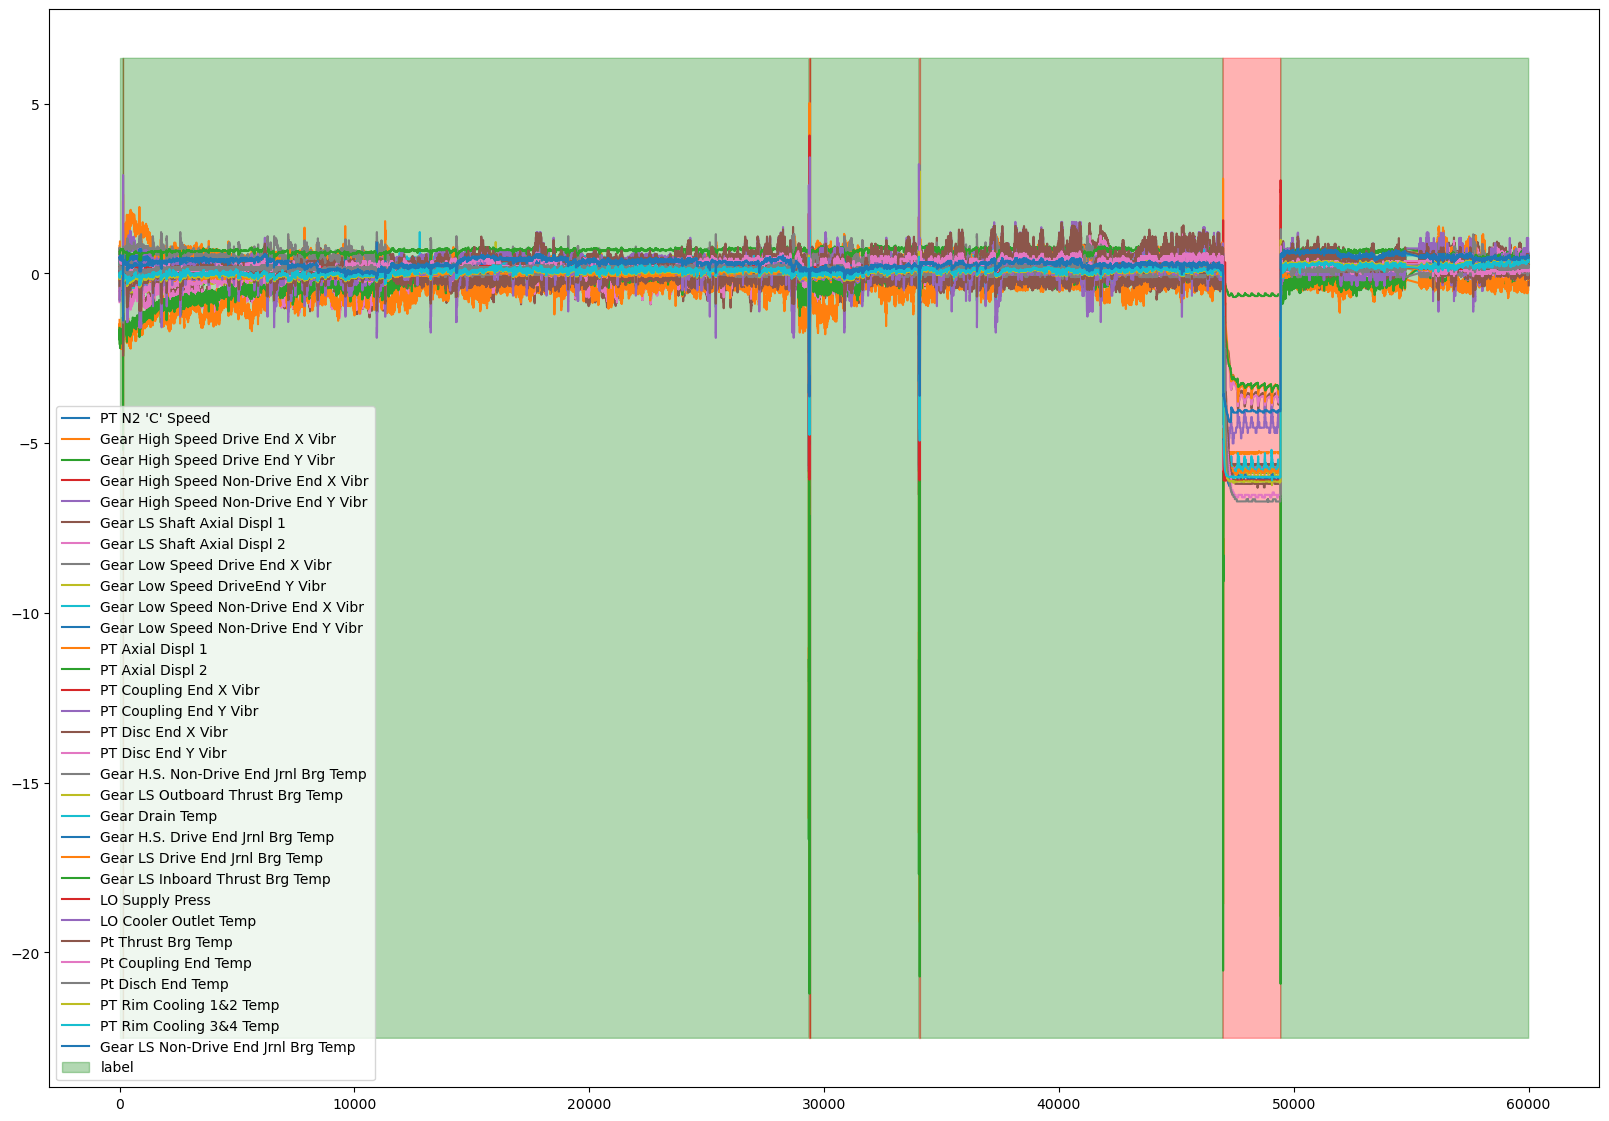

In [11]:
plt.figure(figsize=(20,14))
plt.plot(df_sample_scaled)
xmin, xmax, ymin, ymax = plt.axis()
plt.fill_between(np.arange(0, df_sample_scaled.shape[0]), ymin, ymax, where=(df_sample['label'] == 0), color='green', alpha=0.3)
plt.fill_between(np.arange(0, df_sample_scaled.shape[0]), ymin, ymax, where=(df_sample['label'] == 1), color='red', alpha=0.3)
plt.legend(df_sample.columns)
plt.plot()

In [12]:
df_sample.loc[df_sample['label'] == 0,:].shape

(57449, 32)

In [13]:
df_sample_scaled = scaler.transform(df_sample.loc[df_sample['label'] == 0,:].drop("label", axis=1))

[]

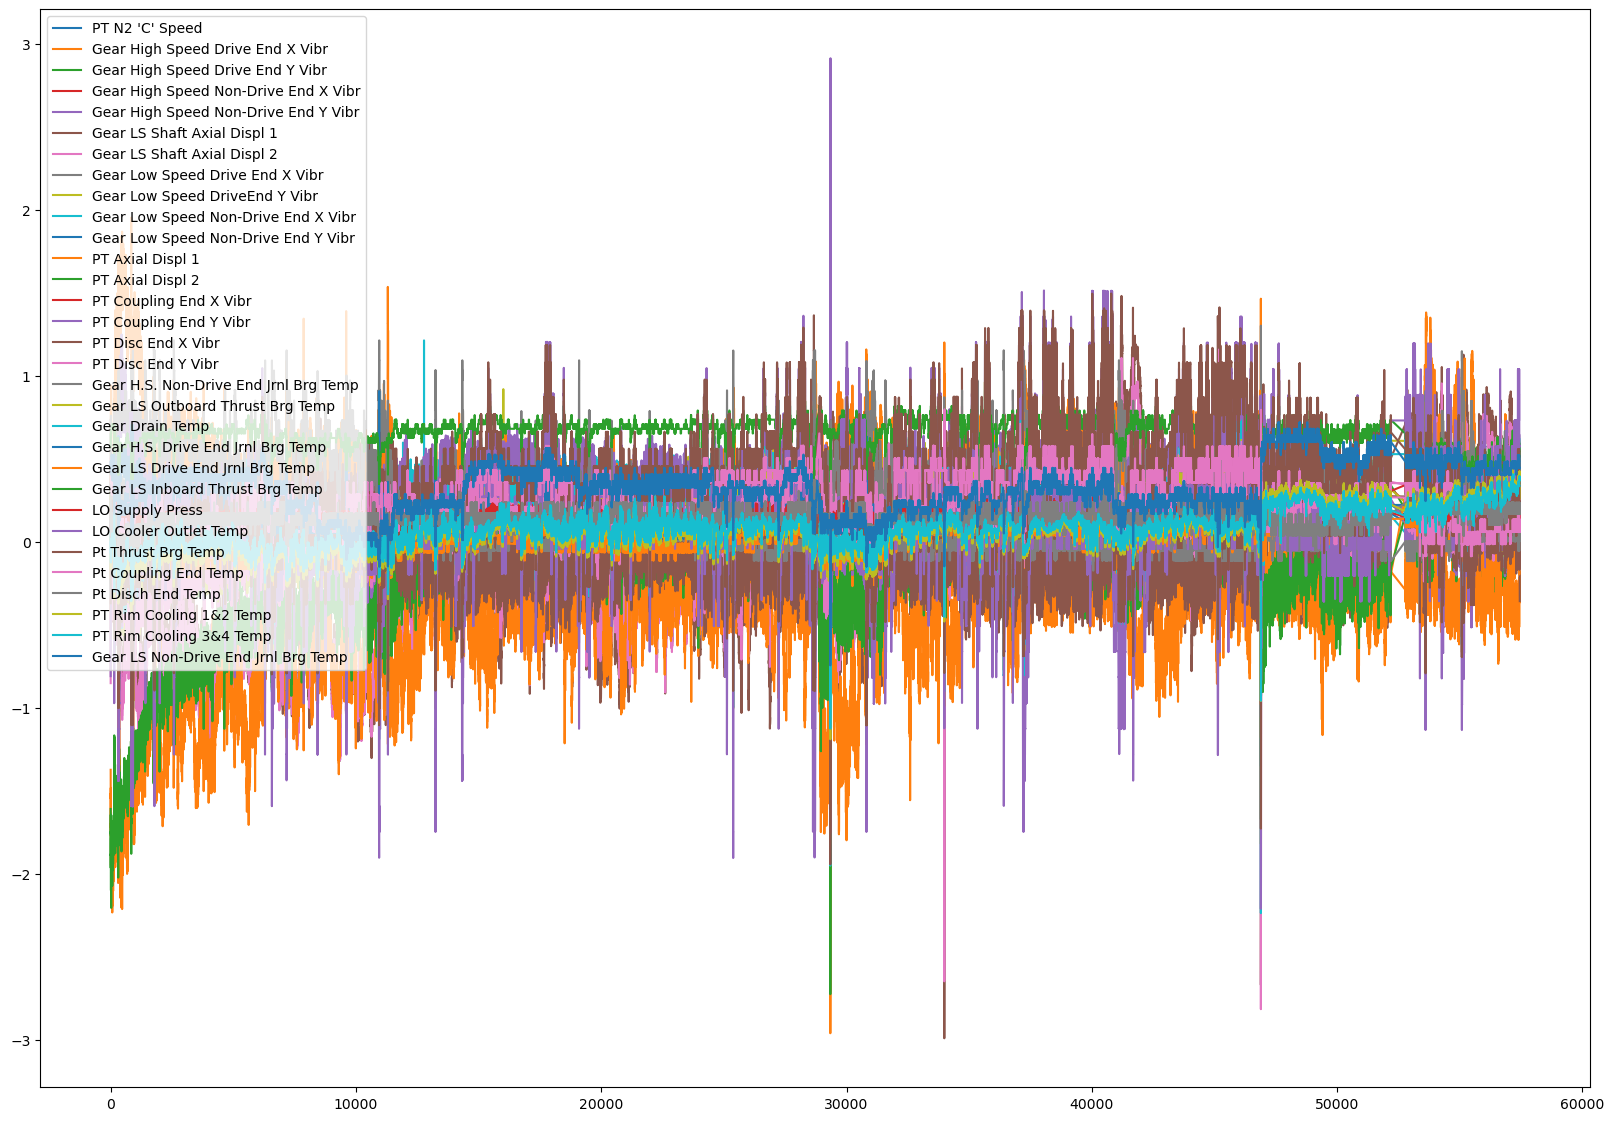

In [14]:
plt.figure(figsize=(20,14))
plt.plot(df_sample_scaled)
plt.legend(df_sample.columns)
plt.plot()

In [14]:
df_sample_scaled_3d = convert_time_window(df_sample_scaled, 10)

In [20]:
def create_lstm_autoencoder(timesteps, n_features):
    # Encoder
    input_layer = keras.layers.Input(shape=(timesteps, n_features))
    encoder = keras.layers.LSTM(128, return_sequences=True)(input_layer)
    encoder = keras.layers.LSTM(64, return_sequences=True)(encoder)
    encoder = keras.layers.LSTM(32)(encoder)
    encoder = keras.layers.Dense(24, activation='relu')(encoder)
    encoded_output = keras.layers.Dense(10, activation='relu')(encoder)

    # Decoder
    decoder = keras.layers.Dense(24, activation='relu')(encoded_output)
    decoder = keras.layers.Dense(24, activation='relu')(decoder)
    decoder = keras.layers.RepeatVector(timesteps)(decoder)

    decoder = keras.layers.LSTM(32, return_sequences=True)(decoder)
    decoder = keras.layers.LSTM(64, return_sequences=True)(decoder)
    decoder = keras.layers.LSTM(128, return_sequences=True)(decoder)

    decoded_output = keras.layers.TimeDistributed(keras.layers.Dense(n_features))(decoder)

    # Define the full autoencoder model
    autoencoder = keras.models.Model(inputs=input_layer, outputs=decoded_output, name="Autoencoder")

    return autoencoder


In [22]:
with tf.device('/GPU:0'):
    lstm_model = create_lstm_autoencoder(10, df_sample_scaled.shape[1])
lstm_model.summary()

2024-09-29 11:38:35.405228: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-09-29 11:38:35.405433: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-09-29 11:38:35.405467: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-09-29 11:38:35.575995: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-09-29 11:38:35.576028: I tensorflow/core/common_runtime/gpu/gpu

Model: "Autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10, 31)]          0         
                                                                 
 lstm (LSTM)                 (None, 10, 128)           81920     
                                                                 
 lstm_1 (LSTM)               (None, 10, 64)            49408     
                                                                 
 lstm_2 (LSTM)               (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 24)                792       
                                                                 
 dense_1 (Dense)             (None, 10)                250       
                                                                 
 dense_2 (Dense)             (None, 24)                

In [23]:
def myCallbacks(log_dir):
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
    early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='loss',
    patience=10,
    mode='min')
    model_path = os.path.join(log_dir,'best_model.h5')
    mc = tf.keras.callbacks.ModelCheckpoint(model_path, monitor='loss', mode='min', verbose=1, save_best_only=False)
    return [tensorboard_callback, early_stopping, mc]

In [24]:
lstm_model.compile(loss='mse', optimizer=keras.optimizers.Adam(), metrics=['acc'])

In [25]:
with tf.device('/GPU:0'):
    history = lstm_model.fit(df_sample_scaled_3d, df_sample_scaled_3d, callbacks=myCallbacks('../logs/train-new/1'), epochs=100, batch_size=32)

Epoch 1/100


2024-09-29 11:39:41.477023: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-09-29 11:39:41.975156: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f8bf36550d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-09-29 11:39:41.975196: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA T500, Compute Capability 7.5
2024-09-29 11:39:41.989552: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1727584782.085808  127820 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1793/1795 [============================>.] - ETA: 0s - loss: 0.0117 - acc: 0.8373
Epoch 1: saving model to ../logs/train-new/1/best_model.h5
1795/1795 [==============================] - 49s 24ms/step - loss: 0.0117 - acc: 0.8373
Epoch 2/100
   4/1795 [..............................] - ETA: 40s - loss: 0.0051 - acc: 0.9180

/home/farras/miniconda3/envs/tensor_gpu/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1794/1795 [============================>.] - ETA: 0s - loss: 0.0049 - acc: 0.8940
Epoch 2: saving model to ../logs/train-new/1/best_model.h5
1795/1795 [==============================] - 43s 24ms/step - loss: 0.0049 - acc: 0.8940
Epoch 3/100
1795/1795 [==============================] - ETA: 0s - loss: 0.0041 - acc: 0.9022
Epoch 3: saving model to ../logs/train-new/1/best_model.h5
1795/1795 [==============================] - 48s 27ms/step - loss: 0.0041 - acc: 0.9022
Epoch 4/100
1793/1795 [============================>.] - ETA: 0s - loss: 0.0039 - acc: 0.9044
Epoch 4: saving model to ../logs/train-new/1/best_model.h5
1795/1795 [==============================] - 48s 27ms/step - loss: 0.0039 - acc: 0.9043
Epoch 5/100
1795/1795 [==============================] - ETA: 0s - loss: 0.0037 - acc: 0.9065
Epoch 5: saving model to ../logs/train-new/1/best_model.h5
1795/1795 [==============================] - 48s 27ms/step - loss: 0.0037 - acc: 0.9065
Epoch 6/100
1794/1795 [=========================

## ============================================

In [15]:
lstm_model = keras.models.load_model("../logs/train-new/1/best_model.h5")
train_3d_np = lstm_model.predict(df_sample_scaled_3d)
train_2d_np = inverse_convert_time_window(train_3d_np)

2024-09-29 23:34:31.498498: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-09-29 23:34:31.498687: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-09-29 23:34:31.498723: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-09-29 23:34:31.659389: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-09-29 23:34:31.659420: I tensorflow/core/common_runtime/gpu/gpu

1795/1795 [==============================] - 17s 8ms/step


In [18]:
r_e = calculate_reconstruction_loss(df_sample_scaled, train_2d_np)

In [21]:
print("Max: ", np.max(r_e))
print("Min: ", np.min(r_e))
print("Avg: ", np.mean(r_e))
print("Median: ", np.median(r_e))
print("75%: ", np.percentile(r_e, 75))
print("25%: ", np.percentile(r_e, 25))
print("IQR: ", np.percentile(r_e, 75) - np.percentile(r_e, 25))

Max:  0.5831722671849883
Min:  0.005238698898853624
Avg:  0.03036027381691517
Median:  0.02967873067291247
75%:  0.034154447668272886
25%:  0.025866499823746645
IQR:  0.008287947844526241


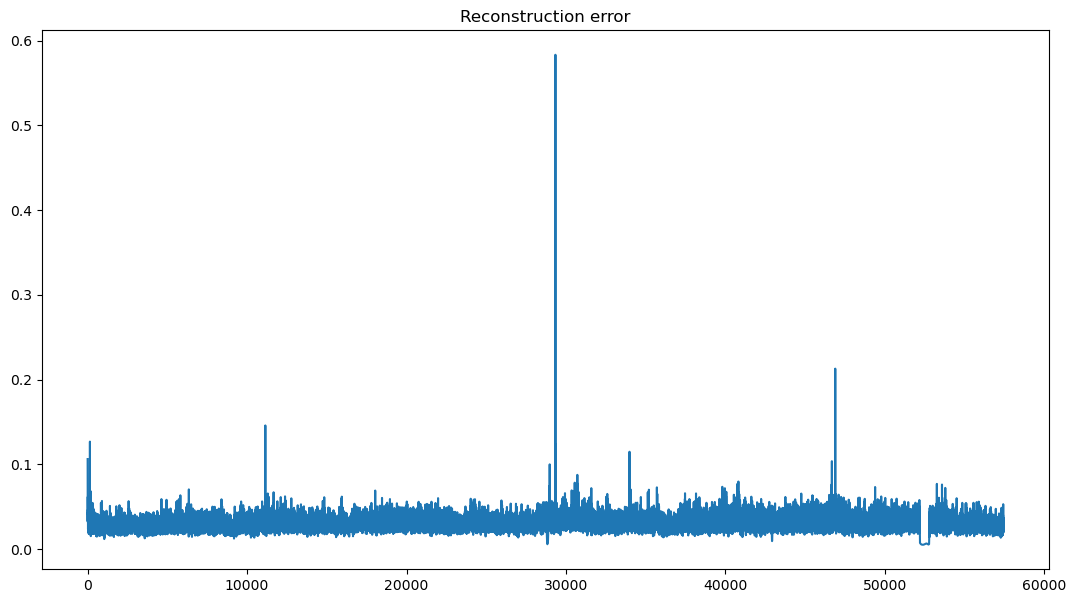

In [20]:
plt.figure(figsize=(13,7))
plt.plot(r_e)
# plt.plot(np.full(r_e.shape[0], thres))
# xmin, xmax, ymin, ymax = plt.axis()
# plt.fill_betweenx(np.arange(thres-iqr, thres+iqr), r_e.shape[0], color='gray', alpha=0.3)
plt.title("Reconstruction error")
plt.show()

## ===============================================

In [22]:
df_sample_test = pd.read_csv("../../datasets/turbine-gas-gearbox/data_sample_test.csv", index_col="Timestamp")
scaler_test = pickle.load(open('StandardScaler-gearbox.pkl', 'rb'))
df_sample_test_scaled = scaler_test.transform(df_sample_test)

In [23]:
df_sample_test_label = np.where(np.any((df_sample_test_scaled < -3) | (df_sample_test_scaled > 3), axis=1), 1, 0)

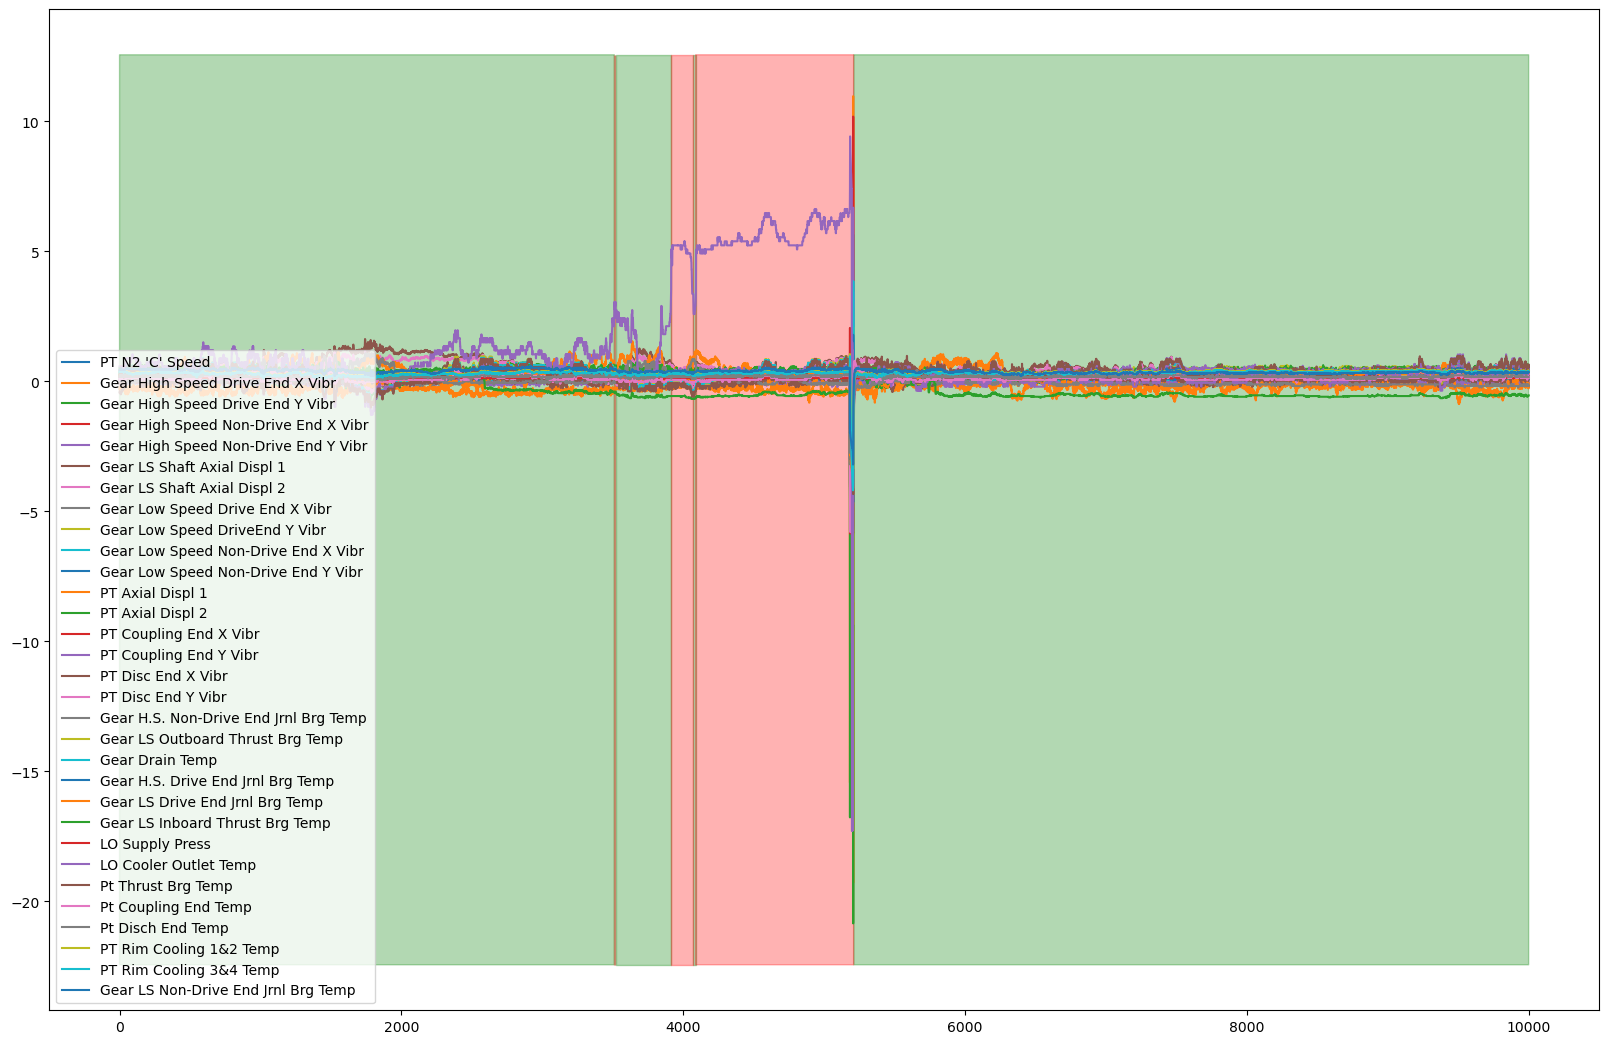

In [24]:
plt.figure(figsize=(20,13))
plt.plot(df_sample_test_scaled)
xmin, xmax, ymin, ymax = plt.axis()
plt.fill_between(np.arange(0, df_sample_test_scaled.shape[0]), ymin, ymax, where=(df_sample_test_label == 0), color='green', alpha=0.3)
plt.fill_between(np.arange(0, df_sample_test_scaled.shape[0]), ymin, ymax, where=(df_sample_test_label == 1), color='red', alpha=0.3)
plt.legend(df_sample_test.columns)
plt.show()

In [25]:
df_sample_test_scaled_3d = convert_time_window(df_sample_test_scaled, 10)

In [26]:
model = keras.models.load_model("../logs/train-new/1/best_model.h5")
model.summary()

Model: "Autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10, 31)]          0         
                                                                 
 lstm (LSTM)                 (None, 10, 128)           81920     
                                                                 
 lstm_1 (LSTM)               (None, 10, 64)            49408     
                                                                 
 lstm_2 (LSTM)               (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 24)                792       
                                                                 
 dense_1 (Dense)             (None, 10)                250       
                                                                 
 dense_2 (Dense)             (None, 24)                

In [27]:
pred = model.predict(df_sample_test_scaled_3d)

313/313 [==============================] - 4s 8ms/step


In [28]:
pred_2d_inv = inverse_convert_time_window(pred)
# r_e = calculate_reconstruction_loss(df_sample_test_scaled, pred_2d_inv)

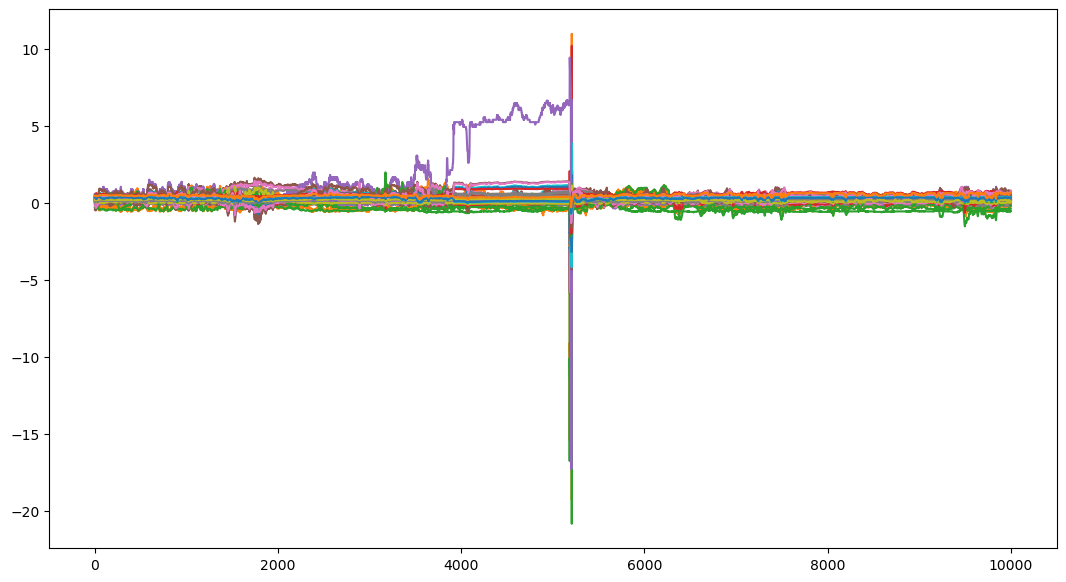

In [29]:
plt.figure(figsize=(13,7))
plt.plot(df_sample_test_scaled)
plt.plot(pred_2d_inv)
plt.show()

In [34]:
r_e = calculate_reconstruction_loss(df_sample_test_scaled, pred_2d_inv)
# thres = 0.5831722671849883
# thres = 0.03036027381691517
thres = 0.034154447668272886 + (1.5 * 0.008287947844526241)

In [36]:
thres, f1, y_pred = find_optimal_threshold((r_e), np.array(df_sample_test_label))
print(thres, f1)

0.3394888134426211 0.9962867730631817


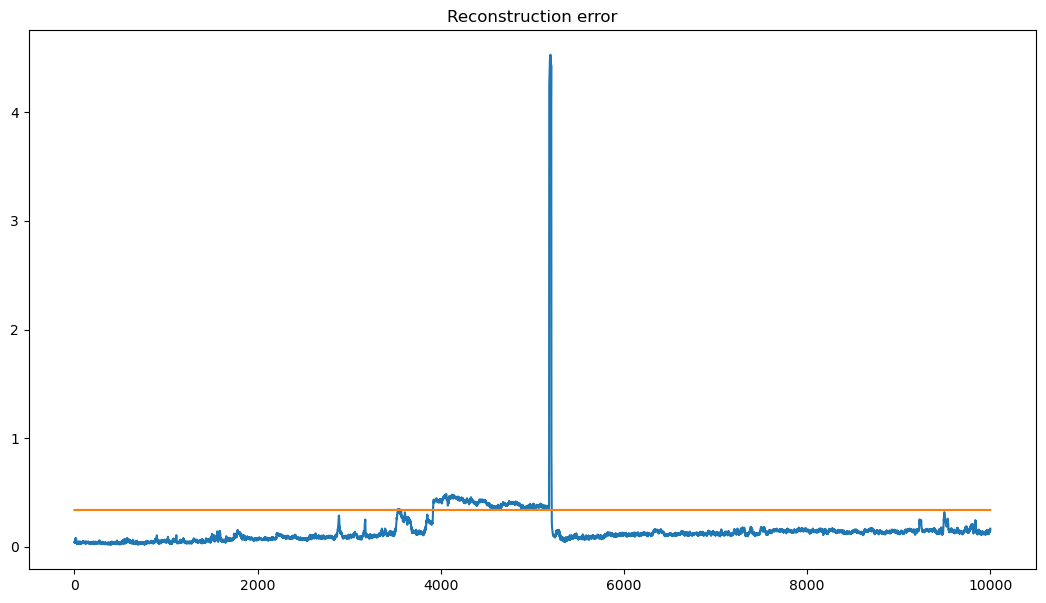

In [37]:
# iqr = np.percentile(r_e, 75) - np.percentile(r_e, 25)

plt.figure(figsize=(13,7))
plt.plot(r_e)
plt.plot(np.full(r_e.shape[0], thres))
xmin, xmax, ymin, ymax = plt.axis()
# plt.fill_betweenx(np.arange(thres-iqr, thres+iqr), r_e.shape[0], color='gray', alpha=0.3)
plt.title("Reconstruction error")
plt.show()

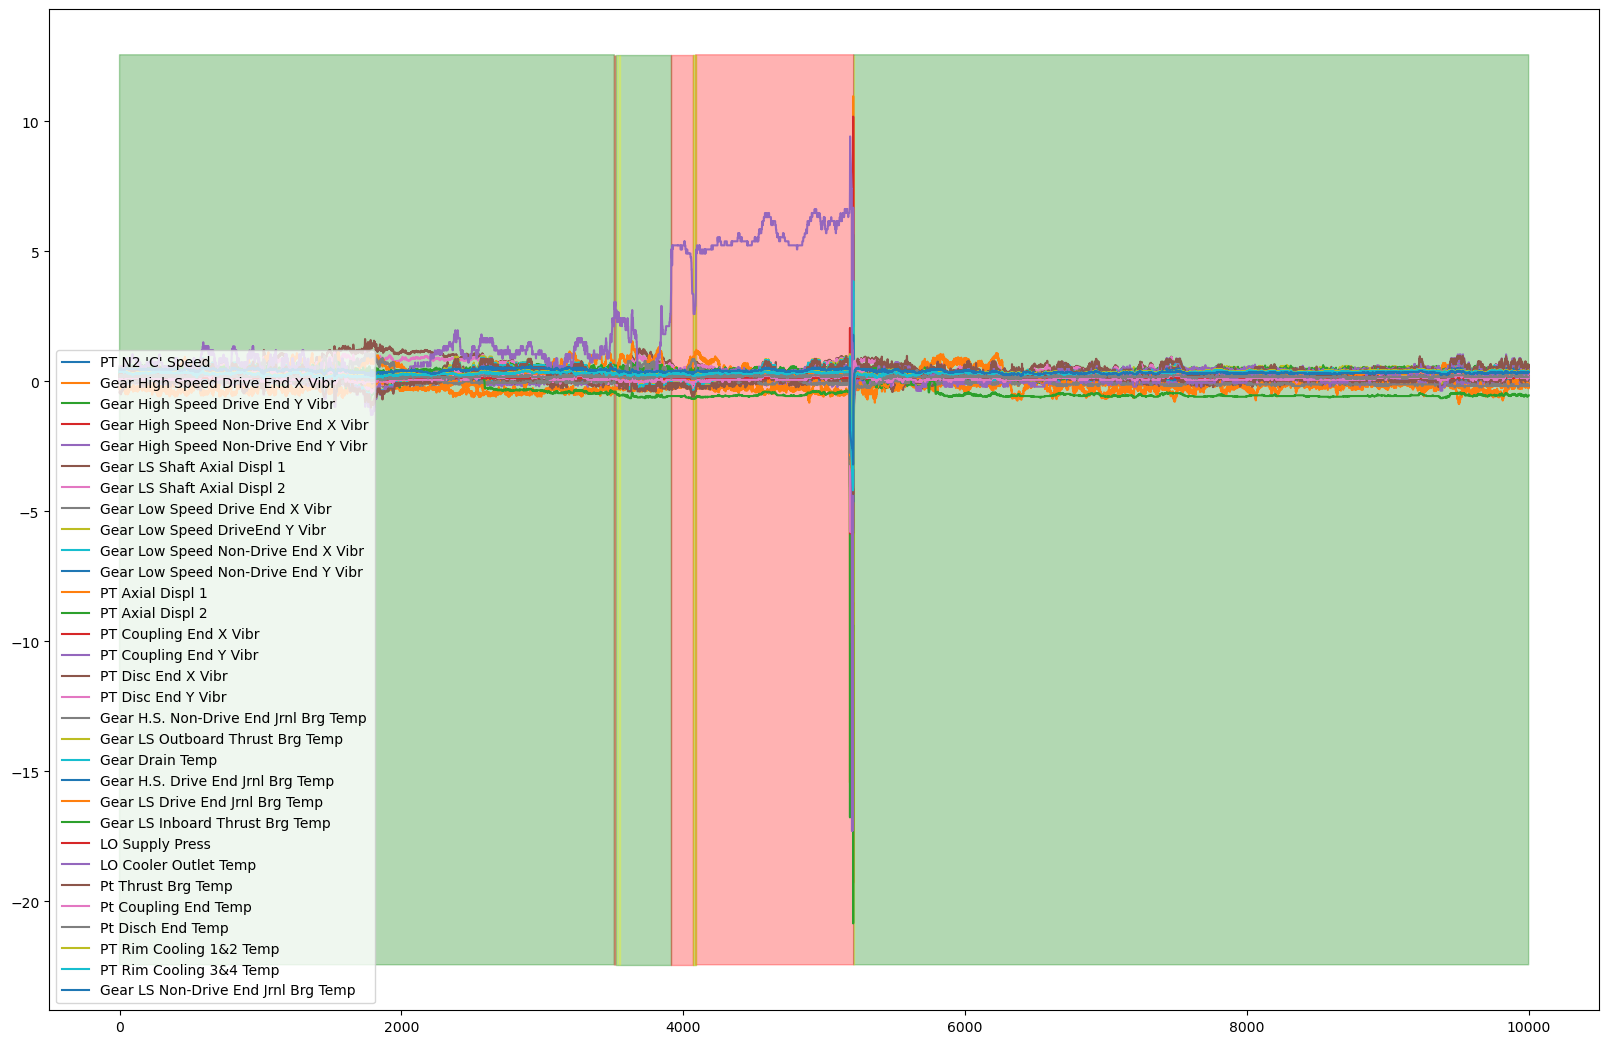

In [38]:
plt.figure(figsize=(20,13))
plt.plot(df_sample_test_scaled)
xmin, xmax, ymin, ymax = plt.axis()
plt.fill_between(np.arange(0, df_sample_test_scaled.shape[0]), ymin, ymax, where=(df_sample_test_label == 0), color='green', alpha=0.3)
plt.fill_between(np.arange(0, df_sample_test_scaled.shape[0]), ymin, ymax, where=(df_sample_test_label == 1), color='red', alpha=0.3)
plt.fill_between(np.arange(0,df_sample_test_scaled.shape[0]), ymin, ymax,where=(~df_sample_test_label.astype(bool) & y_pred ), color='yellow', alpha=0.3)
plt.legend(df_sample_test.columns)
plt.show()

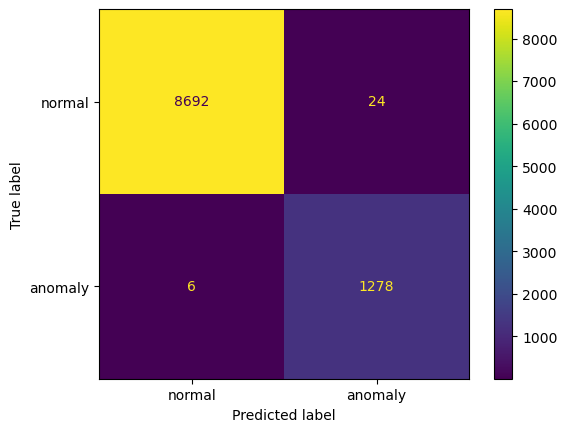

In [39]:
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(np.array(df_sample_test_label).astype(bool), y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['normal', 'anomaly'])
cm_display.plot()